# 02 - Missings (continuação), HoldOut, Métodos ingênuos e Alisamento 
Nessa aula iremos revisar o conteúdo da última aula, apronfudar na estimação de missings e iniciar os métodos mais simples de previsão.

Irei usar alguns exemplos retirados do livro [Time Series Analysis with Python - Cookbook](https://github.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/tree/main).


In [35]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.ar_model import AutoReg


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

def read_dataset(folder, file, date_col=None):
    '''
    folder: is a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a date_col to use as index_col 
    
    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df

def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns) +1
    
    fig, ax = plt.subplots(nrows = subplots_size, ncols = 1, figsize=(12, subplots_size * 6.6), sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0])
    ax[0].set_title('Tabela sem missings')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()

def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores

 ## Dados faltantes - Imputação Univariada

In [36]:
folder = Path('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados')

co2_original = read_dataset(folder, 'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_1928/431820862.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,
/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_1928/431820862.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,


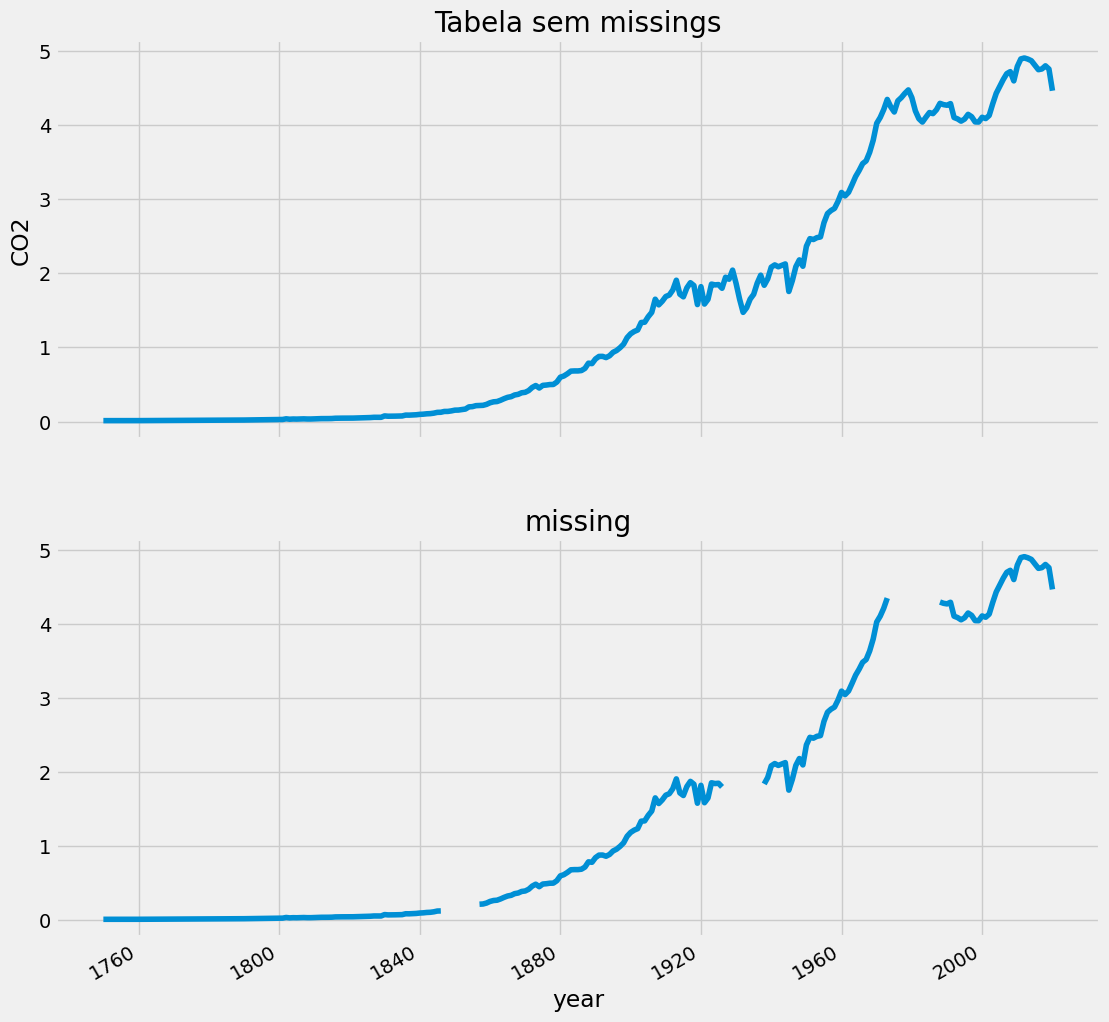

In [37]:
plot_dfs(co2_original, 
         co2_missing, 
         'co2',
         title="Emissões de  CO2 per Capita",
         xlabel="Ano",
         ylabel="CO2")

In [38]:
co2_missing['ffill'] = co2_missing['co2'].ffill()
co2_missing['bfill'] = co2_missing['co2'].bfill()
co2_missing['media'] = co2_missing['co2'].fillna(co2_missing['co2'].mean())
co2_missing['zero'] = co2_missing['co2'].fillna(0)
co2_missing['linear'] = co2_missing['co2'].interpolate(method='linear')
co2_missing['quadratic'] = co2_missing['co2'].interpolate(method='quadratic')

In [39]:
_ = rmse_score(co2_original, 
                    co2_missing, 
                    'co2')

RMSE for ffill: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for media: 0.7156383637041684
RMSE for zero: 1.1285178854727376
RMSE for linear: 0.05507291327761665
RMSE for quadratic: 0.08367561505614347


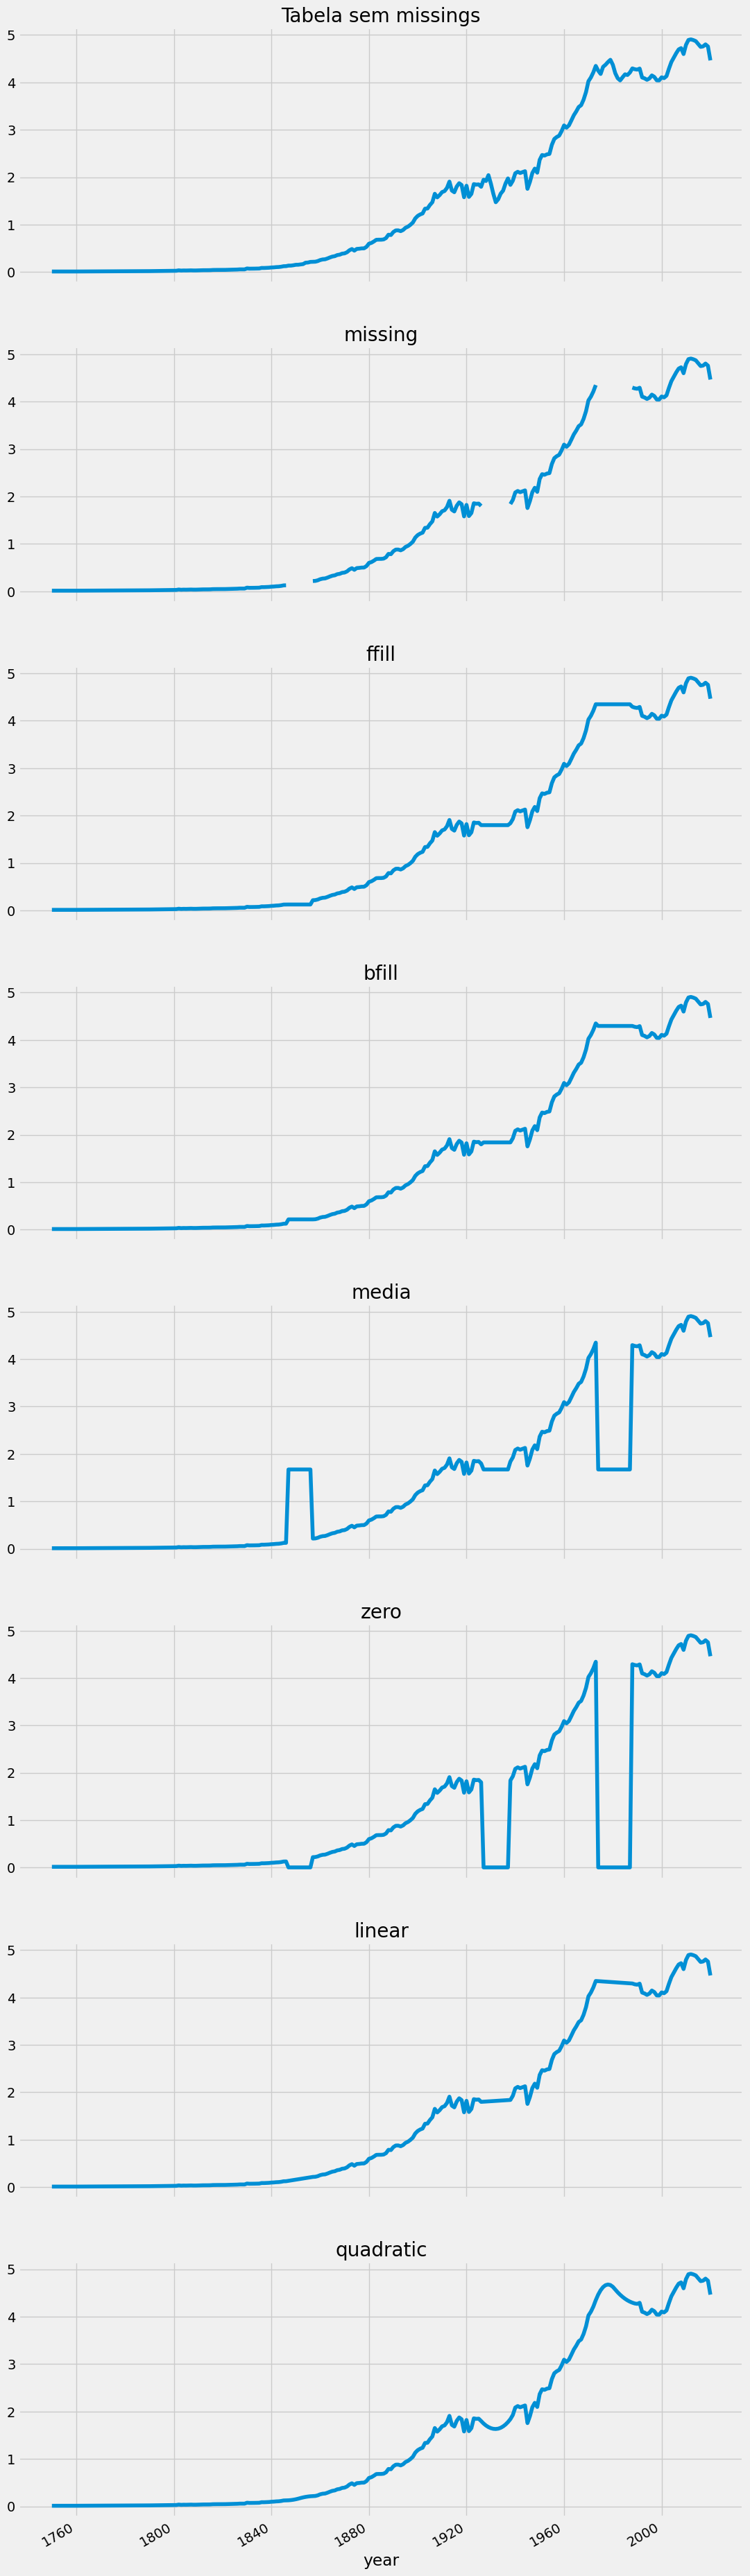

In [40]:
plot_dfs(co2_original, co2_missing, 'co2')

## Imputação Multivariada

In [41]:
clicks_missing.loc['2008-05-10':'2008-05-31']

,price,location,clicks
date,,,
2008-05-10,42.576299,1,4863.0
2008-05-11,43.405890,5,6511.0
2008-05-12,43.258326,2,17426.0
2008-05-13,42.714479,2,4160.0
2008-05-14,43.372786,5,9841.0
2008-05-15,42.517755,2,NaN
2008-05-16,44.011009,2,NaN
2008-05-17,42.530303,2,NaN
2008-05-18,42.565698,5,NaN


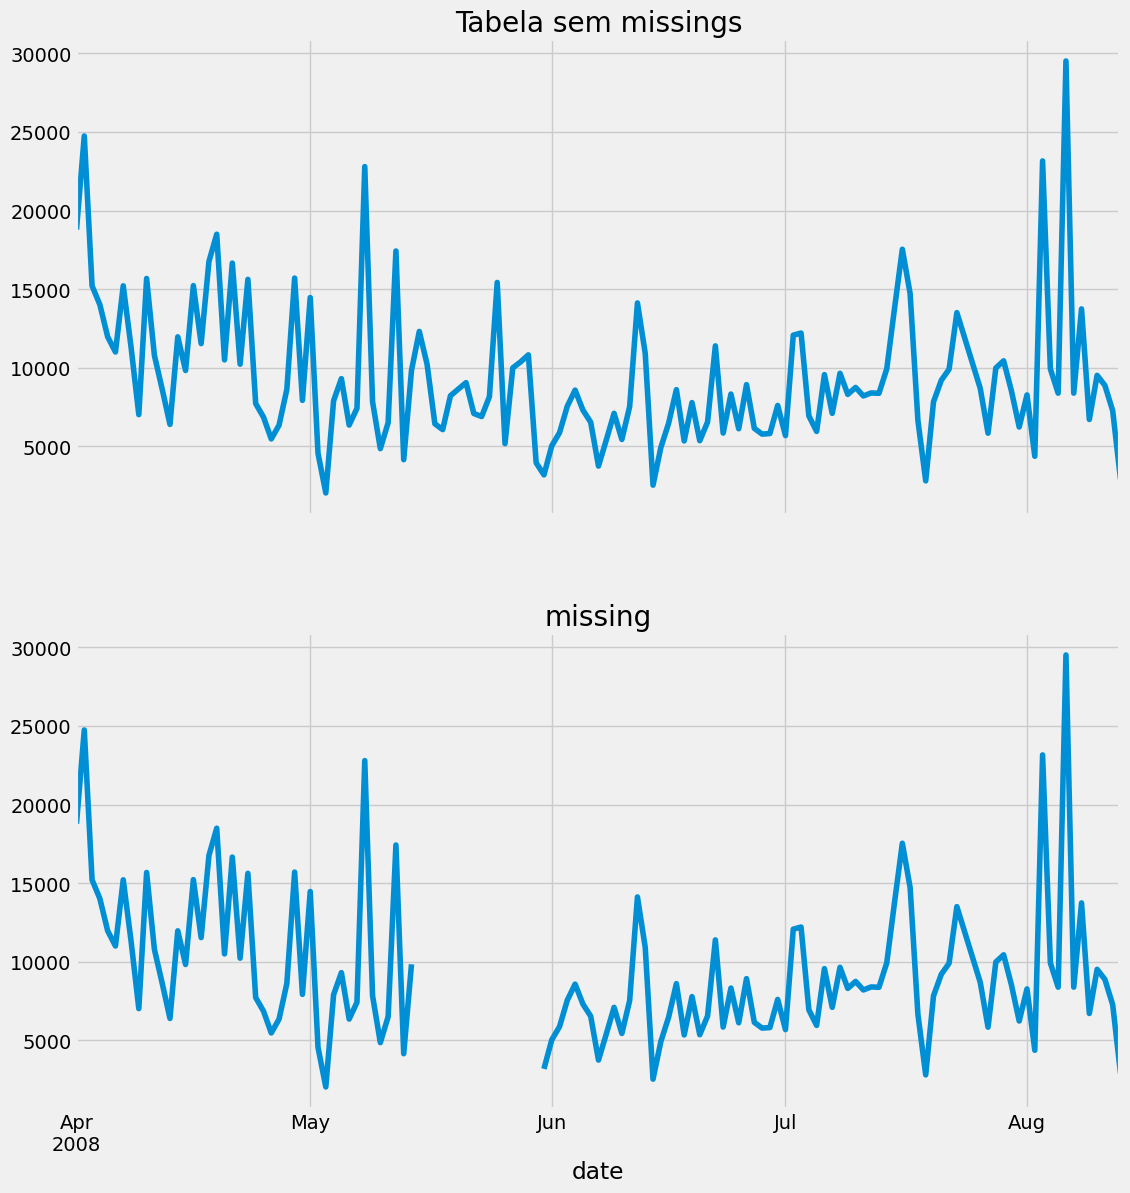

In [42]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

In [43]:
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

In [44]:
estimators = [
    ('bayesianRidge', BayesianRidge()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=10)),
    ('bagging', BaggingRegressor(n_estimators=10)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))]

clicks_vals = clicks_missing.iloc[:,0:3].values
for e_name, e in estimators:
    est = IterativeImputer(
                random_state=15,
                estimator=e).fit(clicks_vals)
    clicks_missing[e_name] = est.transform(clicks_vals)[: , 2]
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.4393973455849
RMSE for extra_trees: 1502.63851676778
RMSE for bagging: 1360.0245582750008
RMSE for elastic_net: 945.4075209343101
RMSE for linear_regression: 938.9419831427186
RMSE for knn: 1336.8798392251822


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


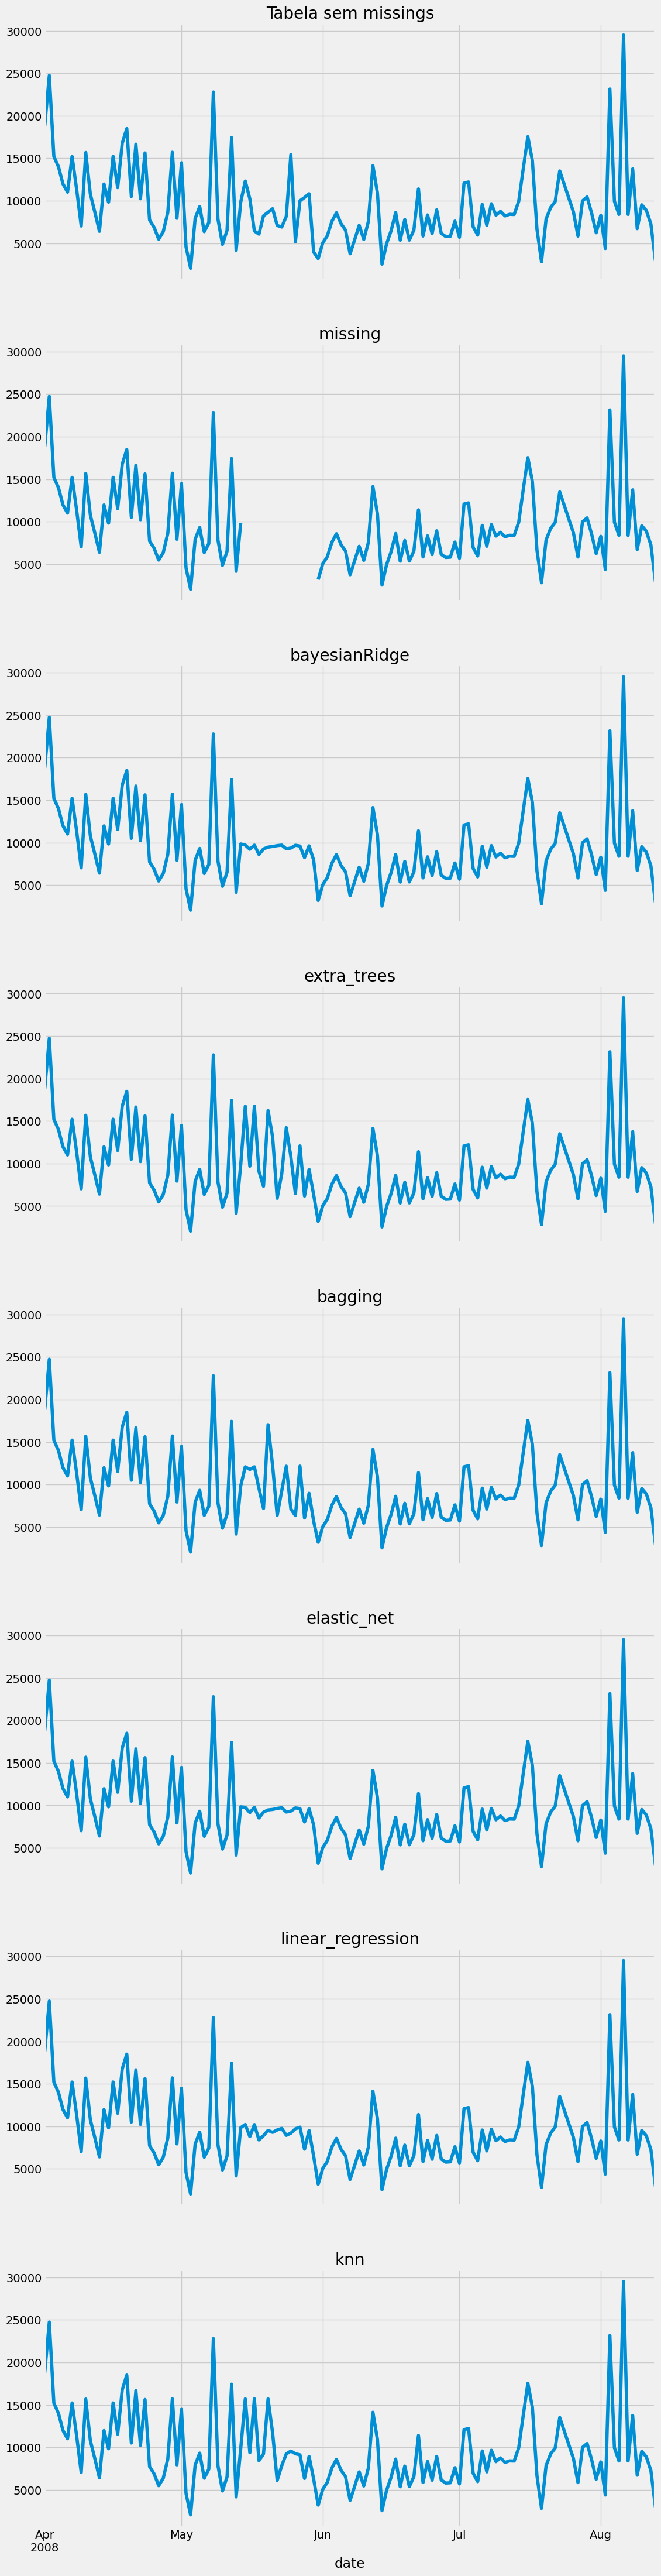

In [45]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

## Holdout
Tabela original

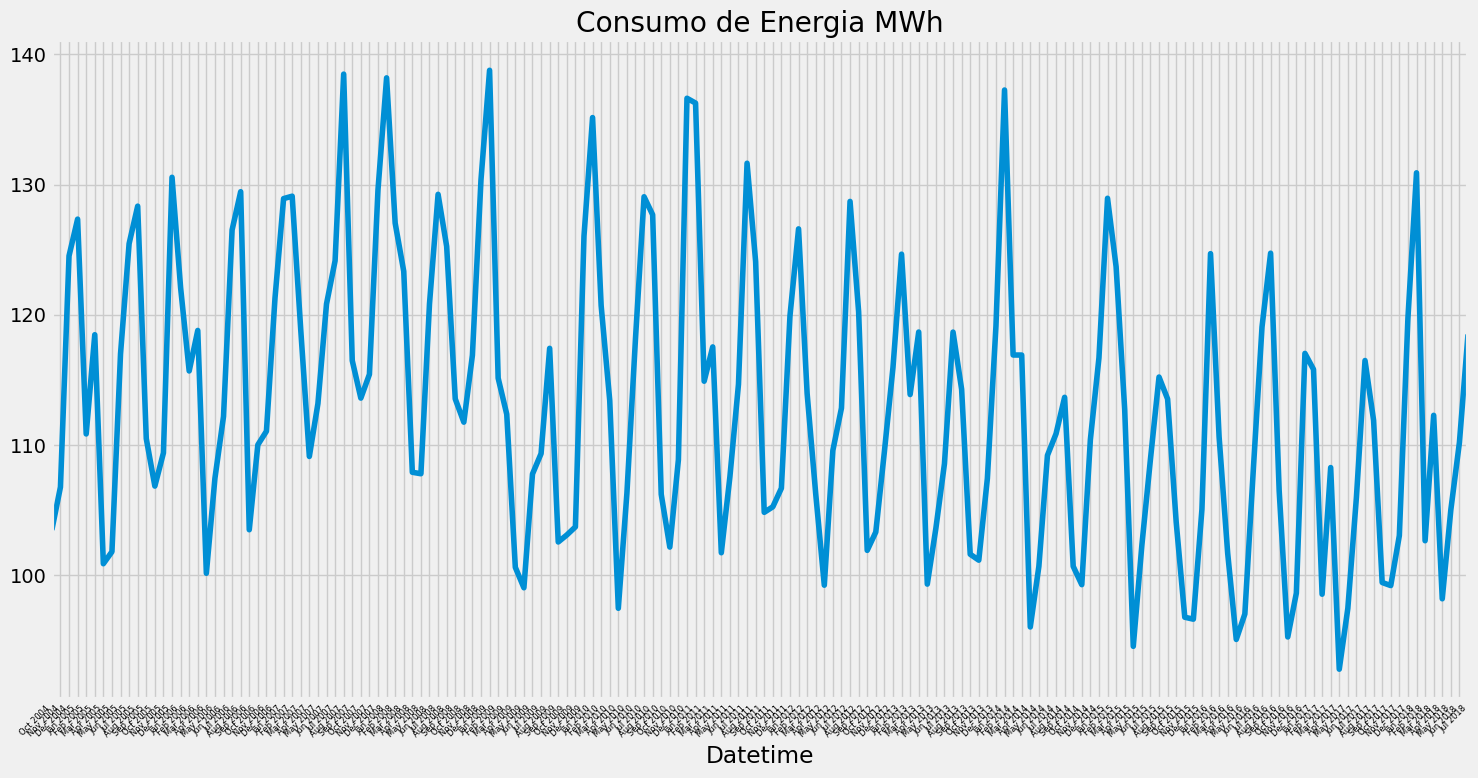

In [46]:
df = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
monthly_data = df.resample('MS').sum()/100000
monthly_data = monthly_data.drop(monthly_data.index[-1])
monthly_data.plot(style='-', figsize=(15, 8), color=color_pal[0], title='Consumo de Energia MWh', legend = False)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b %Y'), rotation=45, ha='right', fontsize=6)
plt.tight_layout()
plt.show()

Vamos usar os últimos 24 meses como HoldOut:

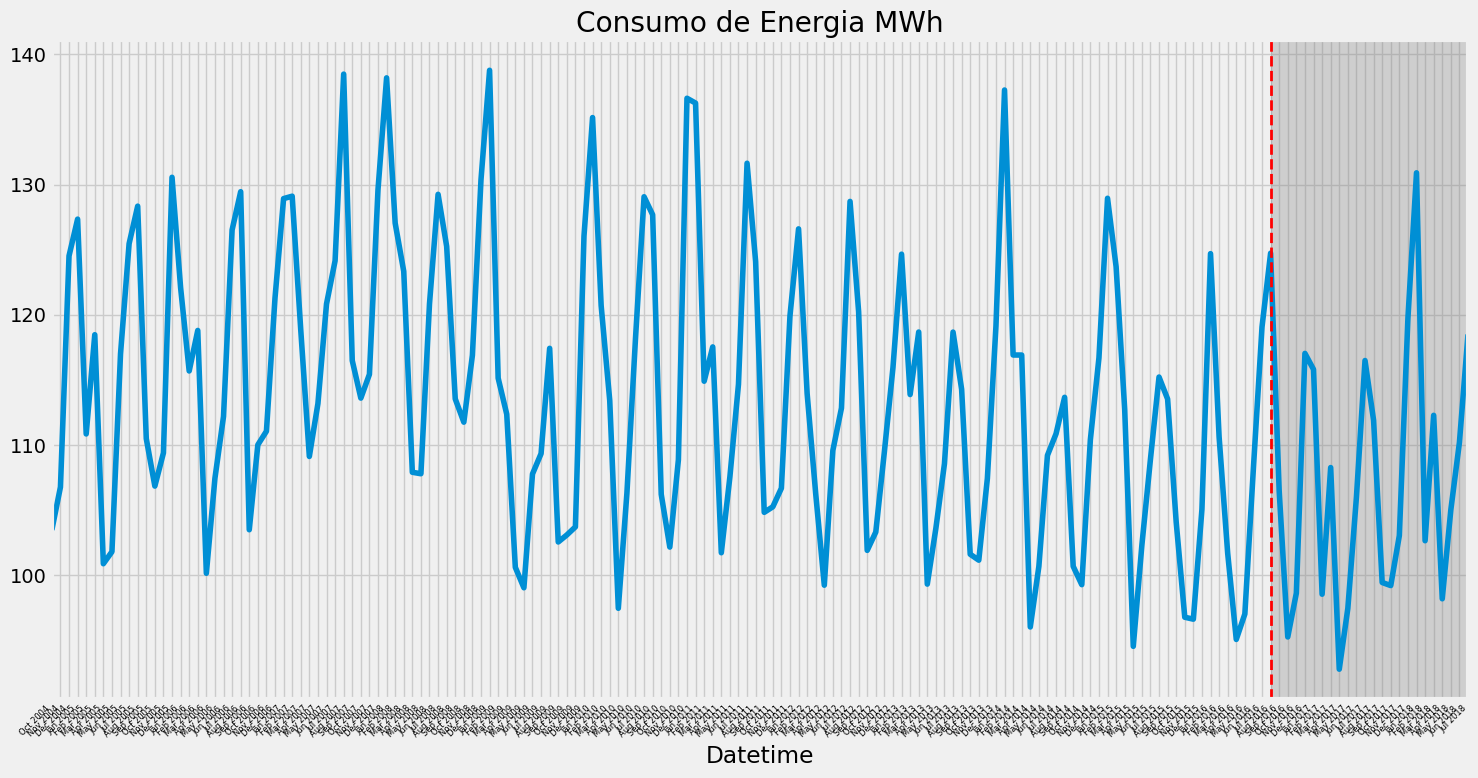

In [47]:
monthly_data.plot(style='-', figsize=(15, 8), color=color_pal[0], title='Consumo de Energia MWh', legend = False)
holdout_start = monthly_data.index[-24]
plt.axvline(holdout_start, color='red', linestyle='--', lw=2)
plt.axvspan(holdout_start, monthly_data.index[-1], color='gray', alpha=0.3)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b %Y'), rotation=45, ha='right', fontsize=6)
plt.tight_layout()
plt.show()

Verificando datas da tabela de treinamento e do holdout:

In [48]:
energy_train = monthly_data[:-24]
energy_holdout = monthly_data[-24:]
print(f'Train start = {energy_train.index.min()}')
print(f'Train end = {energy_train.index.max()}')
print(f'HoldOut start = {energy_holdout.index.min()}')
print(f'HoldOut end = {energy_holdout.index.max()}')

Train start = 2004-10-01 00:00:00
Train end = 2016-07-01 00:00:00
HoldOut start = 2016-08-01 00:00:00
HoldOut end = 2018-07-01 00:00:00


Essa função ajusta um modelo e gera um gráfico com as previsões:

In [ ]:
from typing import Callable

def plot_ts_w_ho(series: pd.Series, fitted_values: pd.Series, forecast: pd.Series, holdout: int, title: str) -> None:
    """
    Plota uma série temporal com período de holdout, valores ajustados e previsão.

    Parâmetros:
    series (pd.Series): Os dados originais da série temporal.
    fitted_values (pd.Series): Os valores ajustados pelo modelo.
    forecast (pd.Series): Os valores previstos pelo modelo.
    holdout (int): O número de períodos a serem mantidos para validação.
    title (str): O título do gráfico.
    """
    holdout_start = series.index[-holdout]
    plt.figure(figsize=(15, 8))
    plt.scatter(series.index, series, color='blue', label='Dados reais')
    plt.plot(fitted_values.index, fitted_values, color='green', linestyle='-', label='Ajuste do modelo')
    plt.plot(forecast.index, forecast, color='green', linestyle='--', label='Previsão')
    plt.axvline(holdout_start, color='red', linestyle='--', lw=2)
    plt.axvspan(holdout_start, series.index[-1], color='gray', alpha=0.3)
    plt.xticks(series.index, series.index.strftime('%b %Y'), rotation=45, ha='right', fontsize=8)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def ts_model_plot(series: pd.Series, method: Callable, holdout: int, forecast_periods: int, title: str, *args, **kwargs) -> None:
    """
    Ajusta um modelo de série temporal e plota os resultados com período de holdout.

    Parâmetros:
    series (pd.Series): Os dados originais da série temporal.
    method (Callable): O método do modelo de série temporal a ser usado para ajuste.
    holdout (int): O número de períodos a serem mantidos para validação.
    forecast_periods (int): O número de períodos a serem previstos.
    title (str): O título do gráfico.
    *args: Argumentos posicionais adicionais a serem passados para o método do modelo.
    **kwargs: Argumentos nomeados adicionais a serem passados para o método do modelo.

    Retorna:
    Nenhum
    """
    model = method(series[:-holdout], *args, **kwargs).fit()
    fitted_values = model.fittedvalues
    forecast = model.forecast(forecast_periods)
    plot_ts_w_ho(series,fitted_values, forecast, holdout,title )

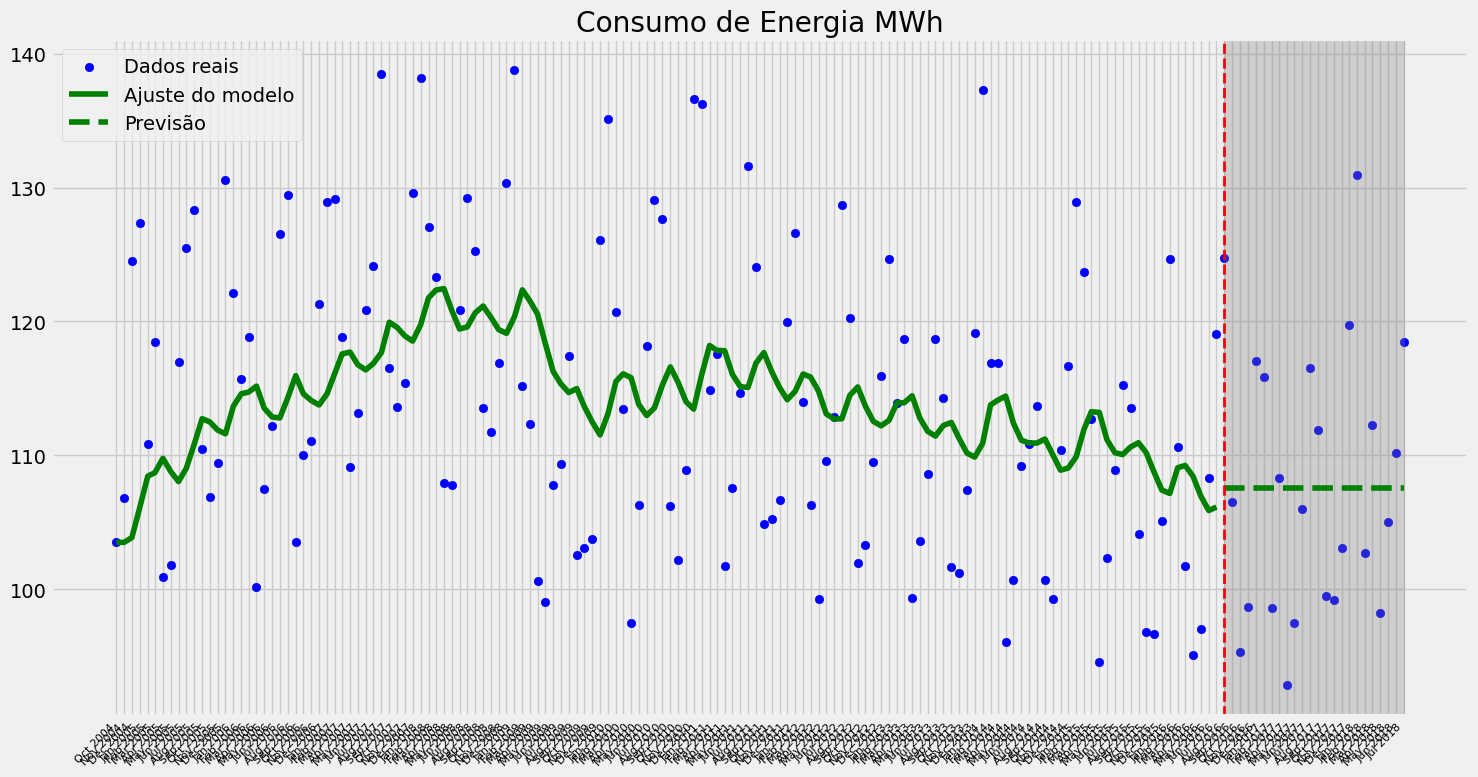

In [50]:
ts_model_plot(monthly_data, SimpleExpSmoothing, 24, 24, 'Consumo de Energia MWh')

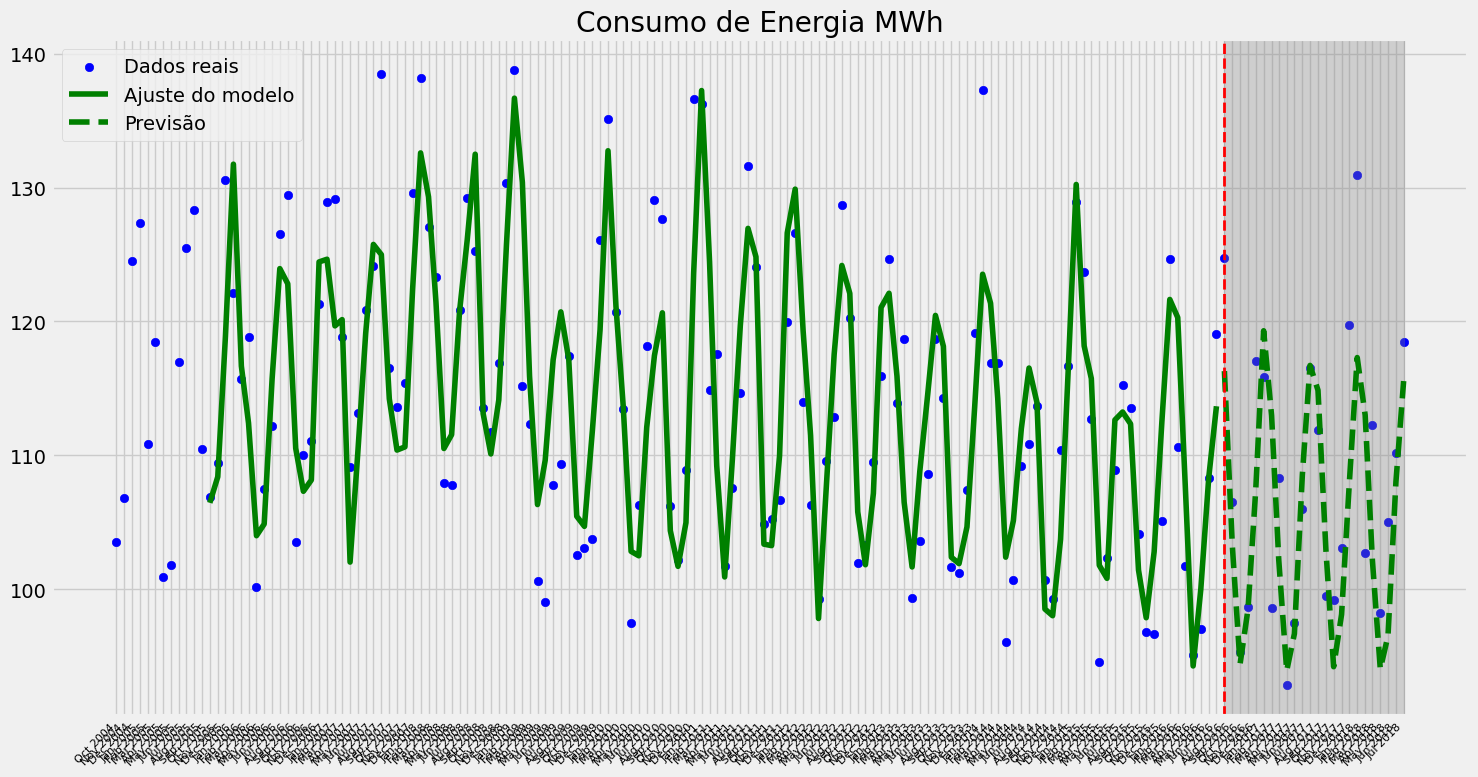

In [51]:
ts_model_plot(monthly_data, AutoReg, 24, 24, 'Consumo de Energia MWh', lags = 12)

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_1928/1955865587.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast = pd.Series([monthly_data.iloc[-holdout-1]]*forecast_periods, index=pd.date_range(start=holdout_start, periods=forecast_periods, freq='M'))
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1398: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


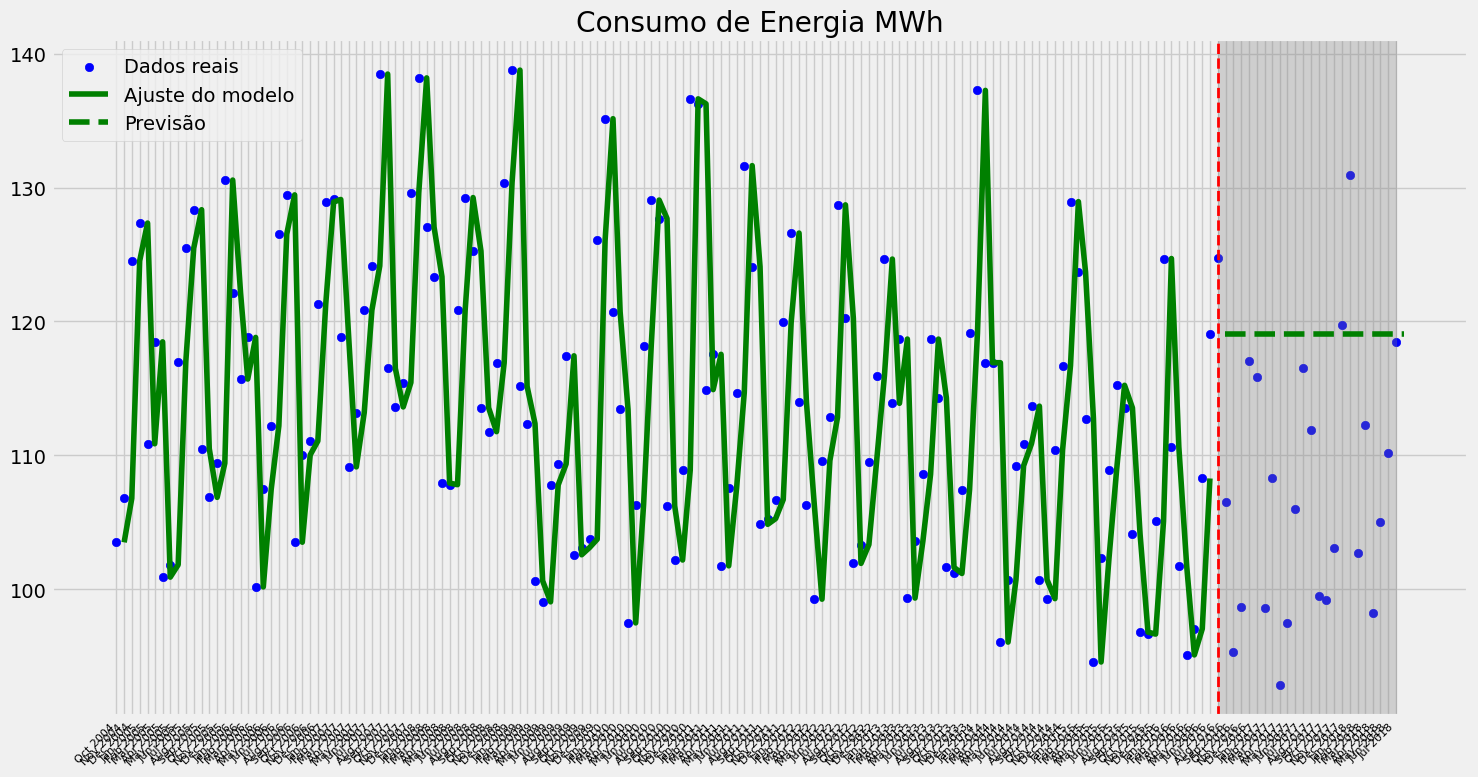

In [52]:
holdout = 24
forecast_periods = 24
holdout_start = monthly_data.index[-holdout]
fitted_values = monthly_data[:-holdout].shift(1)
forecast = pd.Series([monthly_data.iloc[-holdout-1]]*forecast_periods, index=pd.date_range(start=holdout_start, periods=forecast_periods, freq='M'))

plot_ts_w_ho(monthly_data, fitted_values, forecast, holdout, 'Consumo de Energia MWh')
